# 0.0 Imports

## 0.1 Imports

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from pyspark.sql.functions import udf
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, IntegerType, FloatType, LongType, ShortType

from pyspark.ml.pipeline import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay


## 0.2 Starting Spark Session

In [2]:
spark = (SparkSession
.builder
.appName('Fraud')
.getOrCreate())

spark

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/26 14:27:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 0.3 Helper Functions



In [3]:
import matplotlib.pyplot as plt

def jupyter_settings():
    %matplotlib inline
    # %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16
    plt.rcParams['figure.facecolor'] = 'white'
    
    # display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    # sns.set()

jupyter_settings()

def proba_to_pandas(dataframe, prob_col:str, label_col:str):
    """
    Converts a PySpark SQL DataFrame's probability and label columns to a pandas dataframe.
    """
    # convert to pandas df
    result = dataframe.select([prob_col, label_col]).toPandas()
    
    # rename cols
    result.columns = ['y_pred', 'y_true']

    # select proba of positive class
    result['y_pred'] = result['y_pred'].apply(lambda x : x[1])
    
    return result

def describe_stats(dataframe):
    """
    Calculates min, max, mean, std, skewnewss and kurtosis for the given pyspark df
    and returns a pandas df with the results.
    """
    import pyspark.sql. functions as funcs
    num_cols = [f.name for f in dataframe.schema.fields if isinstance(f.dataType, (DoubleType, IntegerType, FloatType, LongType, ShortType))]

    min = []
    max = []
    mean = []
    std = []
    skewness = []
    kurtosis = []

    for col in num_cols:
        # evaluates each metric, collect (to execute) and extracts the result to append to lis
        min.append( data.agg( funcs.min(col) ).collect()[0][0] )
        max.append( data.agg( funcs.max(col) ).collect()[0][0] )
        mean.append( data.agg( funcs.mean(col) ).collect()[0][0] )
        std.append( data.agg( funcs.stddev(col) ).collect()[0][0] )
        skewness.append( data.agg( funcs.skewness(col) ).collect()[0][0] )
        kurtosis.append( data.agg( funcs.kurtosis(col) ).collect()[0][0] )

    # create a dataframe with results
    res = {'min': min, 'max': max, 'mean': mean, 'std': std, 'skewness': skewness, 'kurtosis': kurtosis}
    return pd.DataFrame(res, index = num_cols)

## 0.4 Data Loading

In [4]:
%%time
data = spark.read.csv('../data/raw/fraud.csv', header = True, inferSchema=True)

CPU times: user 25.2 ms, sys: 657 µs, total: 25.8 ms
Wall time: 38.6 s


In [5]:
data.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

In [6]:
type(data)

pyspark.sql.dataframe.DataFrame

In [7]:
data.dtypes

[('step', 'int'),
 ('type', 'string'),
 ('amount', 'double'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'double'),
 ('newbalanceOrig', 'double'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'double'),
 ('newbalanceDest', 'double'),
 ('isFraud', 'int'),
 ('isFlaggedFraud', 'int')]

## 0.5 Columns Description



**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** -
amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

# 1.0 Data Description


## 1.1 Rename Columns

In [6]:
# new column names
cols = ['step',
 'type',
 'amount',
 'name_orig',
 'old_balance_org',
 'new_balance_org',
 'name_dest',
 'old_balance_dest',
 'new_balance_dest',
 'is_fraud',
 'is_flagged_fraud']

data = data.toDF(*cols)
data.show()

+----+--------+---------+-----------+---------------+---------------+-----------+----------------+----------------+--------+----------------+
|step|    type|   amount|  name_orig|old_balance_org|new_balance_org|  name_dest|old_balance_dest|new_balance_dest|is_fraud|is_flagged_fraud|
+----+--------+---------+-----------+---------------+---------------+-----------+----------------+----------------+--------+----------------+
|   1| PAYMENT|  9839.64|C1231006815|       170136.0|      160296.36|M1979787155|             0.0|             0.0|       0|               0|
|   1| PAYMENT|  1864.28|C1666544295|        21249.0|       19384.72|M2044282225|             0.0|             0.0|       0|               0|
|   1|TRANSFER|    181.0|C1305486145|          181.0|            0.0| C553264065|             0.0|             0.0|       1|               0|
|   1|CASH_OUT|    181.0| C840083671|          181.0|            0.0|  C38997010|         21182.0|             0.0|       1|               0|
|   1|

## 1.2 Data Dimensions

## 1.3 Data Types

## 1.4 NA Check

In [9]:
columns = data.columns


NAs = {col: data[data[col].isNull()].count() for col in columns }

NAs

{'step': 0,
 'type': 0,
 'amount': 0,
 'name_orig': 0,
 'old_balance_org': 0,
 'new_balance_org': 0,
 'name_dest': 0,
 'old_balance_dest': 0,
 'new_balance_dest': 0,
 'is_fraud': 0,
 'is_flagged_fraud': 0}

## 1.5 NA Fillout

## 1.6 Changing Data Types


In [9]:
data.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- name_orig: string (nullable = true)
 |-- old_balance_org: double (nullable = true)
 |-- new_balance_org: double (nullable = true)
 |-- name_dest: string (nullable = true)
 |-- old_balance_dest: double (nullable = true)
 |-- new_balance_dest: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- is_flagged_fraud: integer (nullable = true)



## 1.7 Descriptive Statistics

### 1.7.1 Numerical Attributes

In [83]:
desc = describe_stats(data)
# 8 min to run

In [97]:
desc.style.format("{:,.2f}")

,min,max,mean,std,skewness,kurtosis
step,1.00,743.00,243.40,142.33,0.38,0.33
amount,0.00,"92,445,516.64","179,861.90","603,858.23",30.99,"1,797.96"
old_balance_org,0.00,"59,585,040.37","833,883.10","2,888,242.67",5.25,32.96
new_balance_org,0.00,"49,585,040.37","855,113.67","2,924,048.50",5.18,32.07
old_balance_dest,0.00,"356,015,889.35","1,100,701.67","3,399,180.11",19.92,948.67
new_balance_dest,0.00,"356,179,278.92","1,224,996.40","3,674,128.94",19.35,862.16
is_fraud,0.00,1.00,0.00,0.04,27.78,769.70
is_flagged_fraud,0.00,1.00,0.00,0.00,630.60,"397,658.75"


In [98]:
desc.style.format("{:,.4f}")

,min,max,mean,std,skewness,kurtosis
step,1.0000,743.0000,243.3972,142.3320,0.3752,0.3291
amount,0.0000,"92,445,516.6400","179,861.9035","603,858.2315",30.9939,"1,797.9553"
old_balance_org,0.0000,"59,585,040.3700","833,883.1041","2,888,242.6730",5.2491,32.9649
new_balance_org,0.0000,"49,585,040.3700","855,113.6686","2,924,048.5030",5.1769,32.0670
old_balance_dest,0.0000,"356,015,889.3500","1,100,701.6665","3,399,180.1130",19.9218,948.6734
new_balance_dest,0.0000,"356,179,278.9200","1,224,996.3982","3,674,128.9421",19.3523,862.1558
is_fraud,0.0000,1.0000,0.0013,0.0359,27.7795,769.7024
is_flagged_fraud,0.0000,1.0000,0.0000,0.0016,630.6035,"397,658.7500"


In [ ]:
frauds = prop.iloc[0,1]
non_frauds = prop.iloc[1,1]

print('fraud percentage: {:.4f}%'.format( 100*frauds/(frauds+non_frauds)))


fraud percentage: 0.1291%


### 1.7.2 Categorical Attributes

# 2.0 Feature Engineering

## 2.1 Response Variable Mind Map

## 2.2 Hypothesis List

## 2.3 Selected Hypothesis:

**H1:** 

**H2:** 

**H3:** 

**H4:** 

**H5:** 

**H6:** 

**H7:** 

**H8:** 

**H9:** 

**H10:** 

**H11:** 

## 2.4 Feature Engineering

### 2.4.1 datetime

In [99]:
# defining functions to convert hour to sinusoidal
hour_sin = udf( lambda x: math.sin(2*math.pi*x/24) , DoubleType())
hour_cos = udf( lambda x: math.cos(2*math.pi*x/24) , DoubleType())

In [100]:
# converting hour to sinusoidal using udf

data = data.withColumn( "hour_sin", hour_sin(data.step) )
data = data.withColumn( "hour_cos", hour_cos(data.step) )

data = data.withColumn("hour", data['step']%24.0)
data.select(['hour_sin', 'hour_cos', 'hour']).show(5)

+-------------------+------------------+----+
|           hour_sin|          hour_cos|hour|
+-------------------+------------------+----+
|0.25881904510252074|0.9659258262890683| 1.0|
|0.25881904510252074|0.9659258262890683| 1.0|
|0.25881904510252074|0.9659258262890683| 1.0|
|0.25881904510252074|0.9659258262890683| 1.0|
|0.25881904510252074|0.9659258262890683| 1.0|
+-------------------+------------------+----+
only showing top 5 rows



### 2.4.2 delta percentage of balance

In [102]:
data = data.withColumn('delta_balance_org', (data['new_balance_org'] - data['old_balance_org'])/data['old_balance_org'] )
data = data.withColumn('delta_balance_dest', (data['new_balance_dest'] - data['old_balance_dest'])/data['old_balance_dest'] )

In [103]:
data['delta_balance_org', 'delta_balance_dest'].show()

+--------------------+--------------------+
|   delta_balance_org|  delta_balance_dest|
+--------------------+--------------------+
|-0.05783396811962...|                null|
|-0.08773495223304621|                null|
|                -1.0|                null|
|                -1.0|                -1.0|
|-0.28079462867593974|                null|
|-0.14514871890085404|                null|
|-0.03879893010180403|                null|
|-0.04464628127775088|                null|
|                -1.0|                null|
|-0.12794271332694143|-0.03697575063248...|
|                -1.0|  13.567277086214846|
|-0.14924510134321897|                null|
|  -0.505076923076923|                null|
|                -1.0|                null|
|-0.00814439339988...|                null|
|                -1.0|   9.134456029903602|
|                -1.0|                null|
|-0.05472962752883345|                null|
|-0.04441182305098191|                null|
|                -1.0|          

### 2.4.3 Nº of transactions done with customer

In [104]:
data[['name_orig']].distinct().count()

# it wont be possible to count the amount of transactions a customer has done with the destination customer
# since we have almost only unique customers

6353307

### Type

In [ ]:
# data[ data['type'] == 'CASH_IN' ].show(5)
# data[ (data['type'] == 'CASH_IN') & (data['isFraud'] == 1) ].show(5)

# data[ data['isFraud'] == 1 ]
# data.filter(data.isFraud == 1).select('type').distinct().show() # frauds only happened on transfer and cash out

# data.filter(data.isFraud == 1).select('nameDest').distinct().count() # 


# 3.0 Variable Selection

In [39]:
# numerical variables

data.dtypes

[('step', 'int'),
 ('type', 'string'),
 ('amount', 'double'),
 ('name_orig', 'string'),
 ('old_balance_org', 'double'),
 ('new_balance_org', 'double'),
 ('name_dest', 'string'),
 ('old_balance_dest', 'double'),
 ('new_balance_dest', 'double'),
 ('is_fraud', 'int'),
 ('is_flagged_fraud', 'int'),
 ('hour_sin', 'double'),
 ('hour_cos', 'double'),
 ('hour', 'double'),
 ('delta_balance_org', 'double'),
 ('delta_balance_dest', 'double')]

In [113]:
# Selecting cols and transformers to apply RF

# #('step', 'int'), use later
# ('type', 'string'), # OHE
# ('amount', 'double'), 
# # ('nameOrig', 'string'),
# ('oldbalanceOrg', 'double'),
# ('newbalanceOrig', 'double'),
# # ('nameDest', 'string'),
# ('oldbalanceDest', 'double'),
# ('newbalanceDest', 'double'),
# ('isFraud', 'int'),
# # ('isFlaggedFraud', 'int')

num_cols = ['amount','old_balance_org','new_balance_org','old_balance_dest','new_balance_dest', 'is_flagged_fraud', 'hour_sin','hour_cos','hour','delta_balance_org','delta_balance_dest']
cat_cols = ['type']

# 4.0 Exploratory Data Analysis

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

### 4.1.2 Numerical Variables

### 4.1.3 Categorical Variables

## 4.2 Bivariate Analysis

### **H1.**

### **H2.**


### **H3.**

### **H4.**

### **H5.**

### **H6.**

### **H7.**

### **H8.**

### **H9.**

### **H10.**

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

### 4.3.2 Categorical Attributes

# 5.0 Data Preparation

In [105]:
data.limit(5).toPandas()

,step,type,amount,name_orig,old_balance_org,new_balance_org,name_dest,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,hour_sin,hour_cos,hour,delta_balance_org,delta_balance_dest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0.258819,0.965926,1.0,-0.057834,NaN
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0.258819,0.965926,1.0,-0.087735,NaN
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0.258819,0.965926,1.0,-1.000000,NaN
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0.258819,0.965926,1.0,-1.000000,-1.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0.258819,0.965926,1.0,-0.280795,NaN


## 5.1 Data Preparation

In [106]:
data = data.fillna(0)
data.limit(5).toPandas()

,step,type,amount,name_orig,old_balance_org,new_balance_org,name_dest,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,hour_sin,hour_cos,hour,delta_balance_org,delta_balance_dest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0.258819,0.965926,1.0,-0.057834,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0.258819,0.965926,1.0,-0.087735,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0.258819,0.965926,1.0,-1.000000,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0.258819,0.965926,1.0,-1.000000,-1.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0.258819,0.965926,1.0,-0.280795,0.0


## 5.2 Train Test Split

In [107]:
# train test split yielding 80% 20% split, stratified on response variable

train = data.sampleBy( col='is_fraud', fractions = {0:0.8, 1:0.8}, seed = 42 )
test = data.exceptAll(train)

## 5.3 Pipeline

In [119]:
selected_cols = num_cols + ['type_ohe']

# type category to idx
string_indx = StringIndexer(inputCols=['type'], outputCols=['type_idx'])

# ohe of type category idx
ohe = OneHotEncoder(inputCols=['type_idx'], outputCols=['type_ohe'])

# join everything with untransformed numeric values
vec_asm = VectorAssembler(inputCols= selected_cols, outputCol='features')

# instantiating model
rf = RandomForestClassifier(featuresCol='features', labelCol='is_fraud', seed=42, numTrees=10)

pipeline = Pipeline(stages=[string_indx, ohe, vec_asm, rf])

# 6.0 Feature Selection

## 6.1 Spliting Dataframe into Train Test 

In [120]:
# train test split yielding 80% 20% split, stratified on response variable

train = data.sampleBy( col='isFraud' ,fractions = {0:0.8, 1:0.8}, seed = 42 )
test = data.exceptAll(train)

In [121]:
data.unpersist()

DataFrame[step: int, type: string, amount: double, name_orig: string, old_balance_org: double, new_balance_org: double, name_dest: string, old_balance_dest: double, new_balance_dest: double, is_fraud: int, is_flagged_fraud: int, hour_sin: double, hour_cos: double, hour: double, delta_balance_org: double, delta_balance_dest: double]

In [ ]:
# executing and verifying split results

train.groupBy('isFraud').count().show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      1|   6544|
|      0|5083314|
+-------+-------+



In [ ]:
test.groupBy('isFraud').count().show()

22/04/23 19:19:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:19:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:19:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:19:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:19:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:19:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:19:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:19:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:19:38 WARN RowBasedKeyValueBatch: Calling spill() on

+-------+-------+
|isFraud|  count|
+-------+-------+
|      1|   1669|
|      0|1271093|
+-------+-------+



In [ ]:
data.unpersist()

DataFrame[step: int, type: string, amount: double, nameOrig: string, oldbalanceOrg: double, newbalanceOrig: double, nameDest: string, oldbalanceDest: double, newbalanceDest: double, isFraud: int, isFlaggedFraud: int]

In [122]:
spark.catalog.clearCache()

# 7.0 Model Testing

## 7.1 Random Forest

In [123]:
DTmodel = pipeline.fit(train)

22/04/26 15:56:58 WARN MemoryStore: Not enough space to cache rdd_697_3 in memory! (computed 64.1 MiB so far)
22/04/26 15:56:58 WARN BlockManager: Persisting block rdd_697_3 to disk instead.
22/04/26 15:56:59 WARN MemoryStore: Not enough space to cache rdd_697_2 in memory! (computed 64.1 MiB so far)
22/04/26 15:56:59 WARN BlockManager: Persisting block rdd_697_2 to disk instead.
22/04/26 15:57:23 WARN MemoryStore: Not enough space to cache rdd_697_0 in memory! (computed 144.3 MiB so far)
22/04/26 15:57:23 WARN BlockManager: Persisting block rdd_697_0 to disk instead.
22/04/26 15:57:55 WARN MemoryStore: Not enough space to cache rdd_697_3 in memory! (computed 28.5 MiB so far)
22/04/26 15:57:56 WARN MemoryStore: Not enough space to cache rdd_697_2 in memory! (computed 42.7 MiB so far)
22/04/26 15:57:56 WARN MemoryStore: Not enough space to cache rdd_697_0 in memory! (computed 96.2 MiB so far)
22/04/26 15:58:05 WARN MemoryStore: Not enough space to cache rdd_697_2 in memory! (computed 42.

In [124]:
# model
tree = DTmodel.stages[-1]

# vector asslembler's cols
va_cols = DTmodel.stages[-2].getInputCols()

# model features' importance
feat_imp = tree.featureImportances

# saving in a dict
aux = dict(zip(va_cols, feat_imp))

#sorting 
features = {k: v for k, v in sorted(aux.items(), key = lambda x: x[1], reverse=True) }
features

{'old_balance_org': 0.4069264868993115,
 'new_balance_dest': 0.2469790744650072,
 'old_balance_dest': 0.05017278948381814,
 'delta_balance_org': 0.04293415664158811,
 'amount': 0.03301570611019181,
 'hour_sin': 0.02820867680495259,
 'hour': 0.02273737854653862,
 'hour_cos': 0.0180352420623078,
 'delta_balance_dest': 0.012096151521775535,
 'new_balance_org': 0.008674204354115506,
 'type_ohe': 0.002268049965339607,
 'is_flagged_fraud': 0.0}

In [125]:
results = DTmodel.transform(test)
results.limit(5).toPandas()

22/04/26 16:00:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/26 16:00:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/26 16:00:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/26 16:00:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/26 16:00:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/26 16:00:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/26 16:00:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/26 16:00:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/26 16:00:18 WARN RowBasedKeyValueBatch: Calling spill() on

,step,type,amount,name_orig,old_balance_org,new_balance_org,name_dest,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,hour_sin,hour_cos,hour,delta_balance_org,delta_balance_dest,type_idx,type_ohe,features,rawPrediction,probability,prediction
0,3,PAYMENT,13030.42,C1857063398,13485.00,454.58,M1901752553,0.00,0.00,0,0,0.707107,7.071068e-01,3.0,-0.966290,0.000000,1.0,"(0.0, 1.0, 0.0, 0.0)","(13030.42, 13485.0, 454.58, 0.0, 0.0, 0.0, 0.7...","[9.999389473360385, 0.0006105266396159273]","[0.9999389473360385, 6.105266396159273e-05]",0.0
1,3,CASH_IN,177087.19,C504509135,5963237.56,6140324.75,C1916720513,6412853.73,6235766.54,0,0,0.707107,7.071068e-01,3.0,0.029696,-0.027614,2.0,"(0.0, 0.0, 1.0, 0.0)","[177087.19, 5963237.56, 6140324.75, 6412853.73...","[9.98185223614558, 0.01814776385442124]","[0.998185223614558, 0.001814776385442124]",0.0
2,5,PAYMENT,14144.91,C1623813812,0.00,0.00,M2129554451,0.00,0.00,0,0,0.965926,2.588190e-01,5.0,0.000000,0.000000,1.0,"(0.0, 1.0, 0.0, 0.0)","(14144.91, 0.0, 0.0, 0.0, 0.0, 0.0, 0.96592582...","[9.950156744181067, 0.04984325581893482]","[0.9950156744181065, 0.004984325581893481]",0.0
3,6,PAYMENT,11097.96,C17041642,52937.00,41839.04,M1031486232,0.00,0.00,0,0,1.000000,6.123234e-17,6.0,-0.209645,0.000000,1.0,"(0.0, 1.0, 0.0, 0.0)","(11097.96, 52937.0, 41839.04, 0.0, 0.0, 0.0, 1...","[9.950156744181067, 0.04984325581893482]","[0.9950156744181065, 0.004984325581893481]",0.0
4,6,PAYMENT,37699.34,C831656273,642830.98,605131.64,M1464460851,0.00,0.00,0,0,1.000000,6.123234e-17,6.0,-0.058646,0.000000,1.0,"(0.0, 1.0, 0.0, 0.0)","(37699.34, 642830.98, 605131.64, 0.0, 0.0, 0.0...","[9.971683753536261, 0.028316246463739154]","[0.9971683753536261, 0.0028316246463739154]",0.0


# 8.0. Checking model performance

In [126]:
results_pd = proba_to_pandas(dataframe = results, prob_col='probability', label_col='is_fraud')

22/04/26 16:03:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/26 16:03:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/26 16:03:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/26 16:03:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/26 16:03:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/26 16:03:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/26 16:03:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/26 16:03:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/26 16:03:06 WARN RowBasedKeyValueBatch: Calling spill() on

In [126]:
results_pd.head()

,y_pred,y_true
0,0.001815,0
1,0.001815,0
2,0.001815,0
3,0.001815,0
4,0.001815,0


In [129]:
cm = confusion_matrix(y_true=results_pd.y_true, y_pred=results_pd.y_pred > 0.3)
cm

array([[1271058,      35],
       [    522,    1147]])

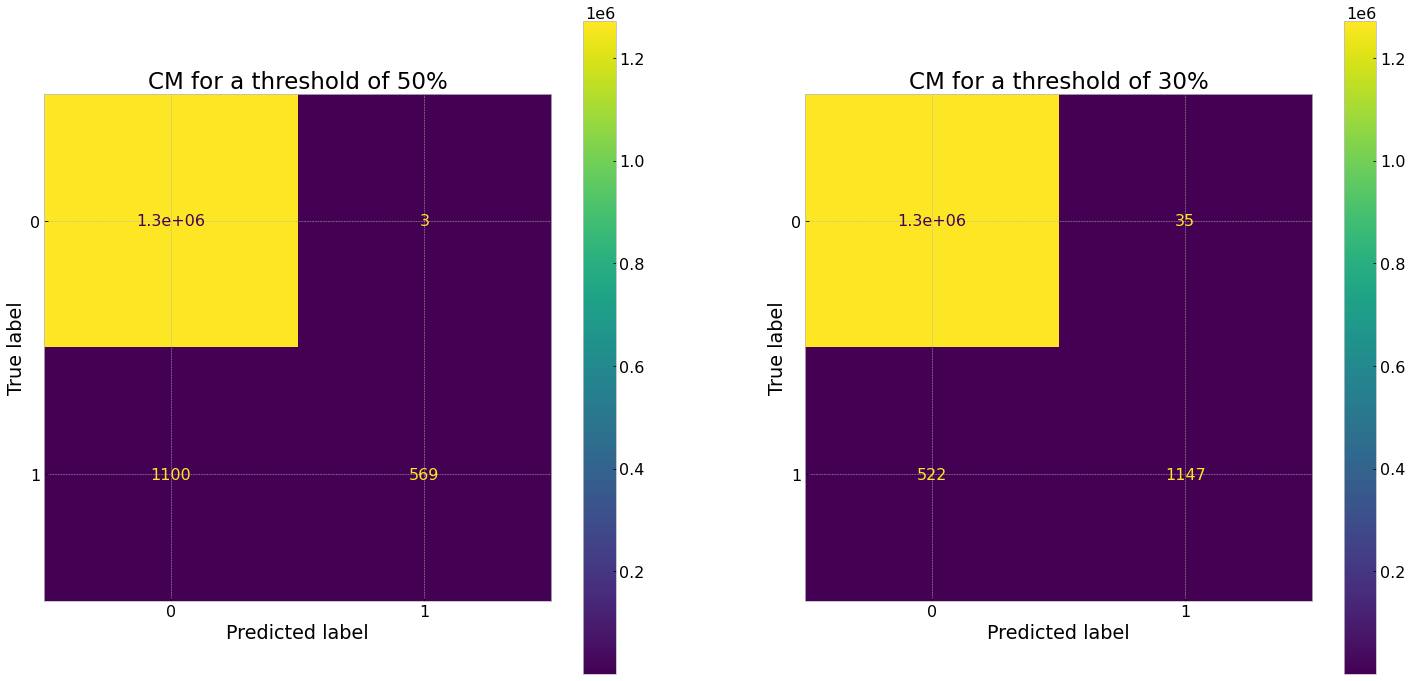

In [127]:
fig, ax = plt.subplots(1,2)

# 50 % threshold
cm = confusion_matrix(y_true=results_pd.y_true, y_pred=results_pd.y_pred > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot(ax = ax[0])
ax[0].set_title('CM for a threshold of 50%')

# 30 % threshold
cm = confusion_matrix(y_true=results_pd.y_true, y_pred=results_pd.y_pred > 0.3)
disp = ConfusionMatrixDisplay(cm)
disp.plot(ax = ax[1])
ax[1].set_title('CM for a threshold of 30%');

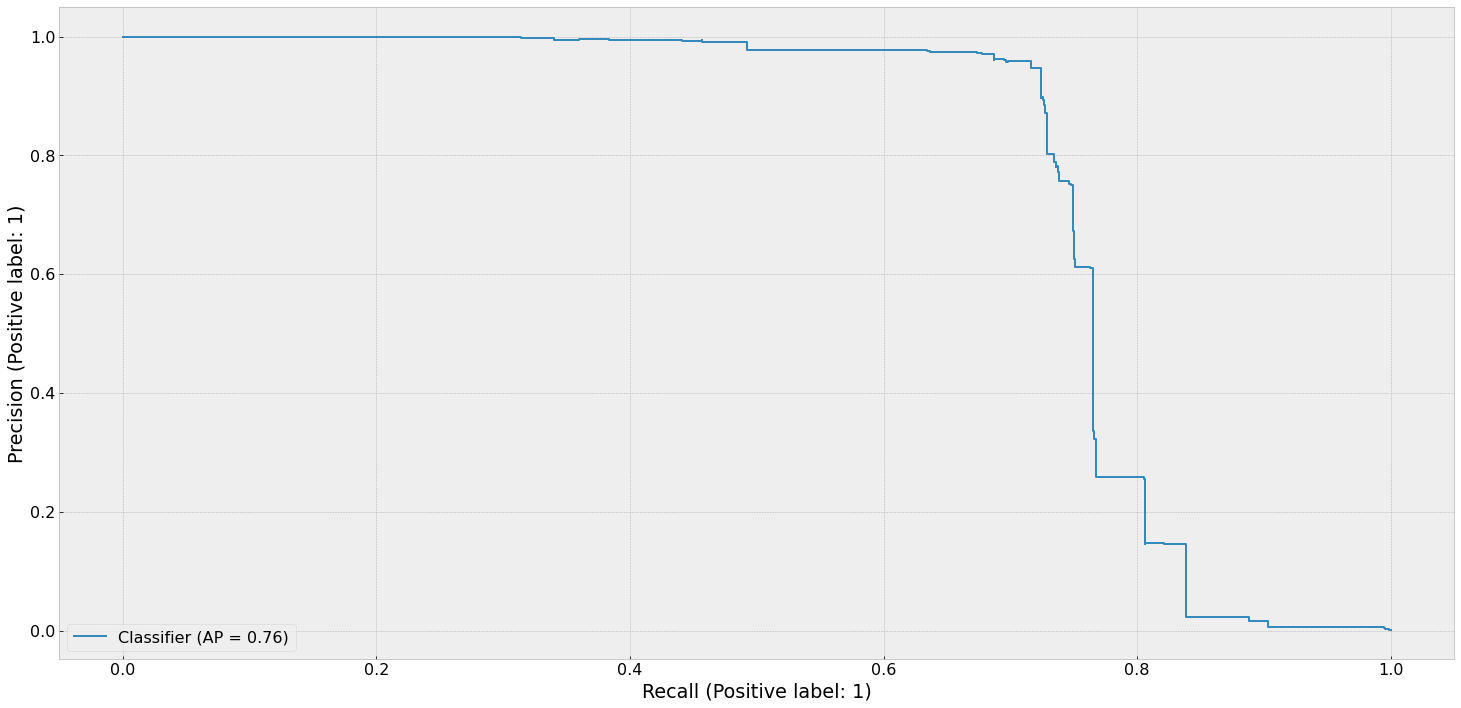

In [128]:
PrecisionRecallDisplay.from_predictions(y_true=results_pd.y_true, y_pred = results_pd.y_pred);

In [150]:
from sklearn.metrics import recall_score, precision_score
# testing a few thresholds

threshold = 0.05
print('precision: {:.4f}'.format(precision_score(y_true=results_pd.y_true, y_pred = results_pd.y_pred > threshold)))
print('recall:    {:.4f}'.format(recall_score(y_true=results_pd.y_true, y_pred = results_pd.y_pred > threshold)))

precision: 0.6257
recall:    0.7513


The precision and recall increased a little bit by adding new features

TODO:
Remove hour sin and cosine

Implement MLFlow tracking

Test other models

Search for new metrics

Perform EDA